<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D1_BayesianStatistics/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 1, Tutorial 1
# Causal inference with mixture of Gaussians

**Tutorial Lecturer:** *Konrad Kording*

**Tutorial Content Creator:** *Vincent Valton*

##Tutorial Objective

Video available at https://youtube.com/watch?v=ium-eaJz9yo


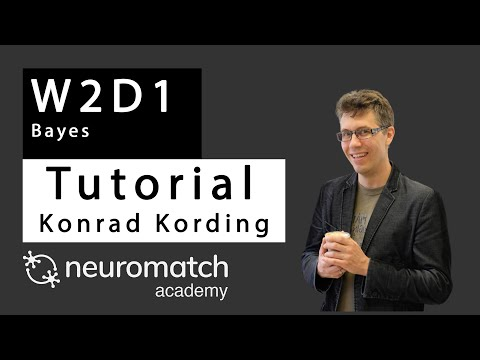

In [1]:
#@title Video: Intro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='ium-eaJz9yo', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---

### Tutorial objectives
  
In this notebook we'll look at creating mixtures of Gaussian distributions by applying a mixing weight to the distributions. 
    
Mathematically, we can control how the Gaussians are mixed by summing them and using a mixing parameter $\alpha$ (comprised between zero and one):

\begin{eqnarray}
    \text{Mixture} = \left[ \alpha \times \mathcal{N_1}(\mu_{1},\sigma_{1}) \right] + \left[ \left( 1 - \alpha \right) \times \mathcal{N_2}(\mu_{2},\sigma_{2}) \right]
\end{eqnarray}

where $\mathcal{N_{1}}$ and $\mathcal{N_{2}}$ are the first and second Gaussian distributions used for the mixture.

Steps:

1. Implement a mixture of Gaussian prior
2. Given Bayes rule, a mixture of Gaussian prior and a Gaussian likelihood, calculate the posterior distribution
3. Create a Mixture of Gaussian prior matrix that repeats the prior over multiple rows of the matrix
4. Create a Likelihood matrix with a different likelihood mean for each row of the likelihood matrix.
5. Create a Posterior matrix that is the result (on each row of the posterior matrix), the combination of the prior and likelihood matrices (row-wise).
6. Create a binary decision matrix that reports the most likely action for each of the row-posteriors of the posterior matrix.

So lets start implementing these steps, one by one.


---
##Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
# imports

import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display


In [3]:
#@title Figure Settings

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
#@title Helper functions
    
def my_gaussian(x_points, mu, sigma):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Returns un-normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`
    
    Args: 
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): un-normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    return np.exp(-(x_points-mu)**2/(2*sigma**2))

def plot_my_composed_prior(x, gaussian1, gaussian2, combined):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots a prior made of a mixture of gaussians
    
    Args: 
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for auditory likelihood evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for visual likelihood evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
             
    Returns:
      Nothing
    """
    plt.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    plt.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    plt.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    plt.legend()
    plt.ylabel('Probability')
    plt.xlabel('Orientation (Degrees)')

def my_dynamic_plot(x, prior, likelihood, posterior_pointwise):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots the prior, likelihood and posterior distributions and update the figure
    
    Args: 
      x (numpy array of floats):         points at which the likelihood has been evaluated
      auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
      visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
      
    Returns: 
      Nothing
    """

    plt.clf()
    plt.plot(x, prior, '-r', LineWidth=2, label='Prior')
    plt.plot(x, likelihood, '-b', LineWidth=2, label='Likelihood')
    plt.plot(x, posterior_pointwise, '-g', LineWidth=2, label='Posterior')
    plt.ylabel('Probability')
    plt.xlabel('Orientation (Degrees)')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.2)

def plot_mymatrix(x, matrix, xlabel, ylabel, title):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Plots a matrix

  Args : 
    x (numpy array of floats): values where matrix is evaluated
    matrix (numpy array of floats) 
    xlabel (string) : label of x-axis
    ylabel (string) : label of y-axis
    title  (string) : title of plot

  Returns:
    None
  """
  plt.figure(figsize=(fig_w*1.2, fig_h))
  plt.pcolor(matrix, edgecolors='w', linewidths=1)
  plt.colorbar()
  plt.xticks(np.arange(x.shape[0]), x)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()
  

---
## a. Implement a mixture of Gaussians
   
We now want to create a mixture of Gaussian probability density functions (PDFs), that we'll use as a prior in subsequent exercises.

We provide you with ready-to-use plotting functions, and a code skeleton to plot the resulting PDF.

**Suggestions**
* Using the equation for the un-normalised Gaussian `my_gaussian`:
  * Generate a Gaussian with mean 0 and standard deviation 0.5
  * Generate another Gaussian with mean 0 and standard deviation 10
   * Combine the two Gaussians to make a new prior by mixing the two Gaussians with mixing parameter $\alpha$ = 0.05. Make it such that the peakier Gaussian has 95% of the weight (don't forget to normalize afterwards)
* Using the function `plot_my_composed_prior` provided, plot the resulting mixture of gaussian
* Play with the means and variance of the two Gaussians and observe the resulting distribution to get an intuition of how the parameters affect the mixture.

**Helper function(s)**


In [5]:
help(plot_my_composed_prior)

Help on function plot_my_composed_prior in module __main__:

plot_my_composed_prior(x, gaussian1, gaussian2, combined)
    DO NOT EDIT THIS FUNCTION !!!
    
    Plots a prior made of a mixture of gaussians
    
    Args: 
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for auditory likelihood evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for visual likelihood evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
             
    Returns:
      Nothing



###Exercise 1

In [6]:
x = np.arange(-10, 11, 0.1)

prior_mean = 0.
prior_sigma1  = .5
prior_sigma2  = 3.
alpha = 0.05

###############################################################################
## Insert your code here to:
##        Create a Gaussian prior made of two Gaussians
##        Both with mean 0 and standard deviation 0.5 and 3 respectively
##        Make the combined prior (made of the two Gaussians) by weighing it
##        using a mixing parameter alpha = 0.05 such that the peakier Gaussian has
##        weight 0.95
##        Plot the two Gaussian and the resulting mixture using the function `plot_my_composed_prior`
###############################################################################


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_03d850de.py)

*Example output:*

<img alt='Solution hint' align='left' width=613 height=477 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_03d850de_0.png>



<img src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/static/sample_output.png"/>

<img width="450px" src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/Bayes/Expected_outputs/Student_BayesDay_Tutorial_2_fig_1.jpg"/>

---
## b. Bayes with mixture of Gaussians

Video available at https://youtube.com/watch?v=SYTaSvW_rpE


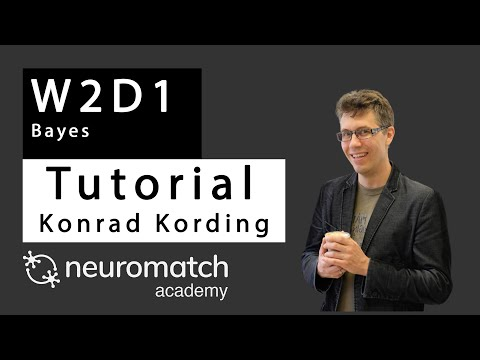

In [8]:
#@title Video: Bayes with mixture of Gaussians
video = YouTubeVideo(id='SYTaSvW_rpE', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

  
We now want compute the posterior using *Bayes rule*, having the mixture of Gaussian as a prior, and a Gaussian likelihood.

Using the provided plotting function `my_dynamic_plot`, we'll see how the 'fat-tails' of the Gaussian mixture affects the linearity of the posterior mode as a function of the stimulus position.

**Suggestions**

   Using the Gaussian mixture from exercise 1 as a prior:

* Allow the mean of the Gaussian likelihood to vary from -8 to 8 in steps of 0.2 degree, keeping $\sigma$ of the visual stimuli to 1.
* In a loop, calculate the posterior for each visual stimulus, and call the `my_dynamic_plot` function to plot it.
* Calculate the mode of the posterior and plot it against the visual stimulus mean. 
   
What do you observe?

**Helper function(s)**


In [9]:
help(my_dynamic_plot)

Help on function my_dynamic_plot in module __main__:

my_dynamic_plot(x, prior, likelihood, posterior_pointwise)
    DO NOT EDIT THIS FUNCTION !!!
    
    Plots the prior, likelihood and posterior distributions and update the figure
    
    Args: 
      x (numpy array of floats):         points at which the likelihood has been evaluated
      auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
      visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
      
    Returns: 
      Nothing



###Exercise 2

In [10]:
x = np.arange(-10, 11, 0.1)

visual_mean = np.arange(-8, 9, 0.2)
visual_sigma  = 1.

###############################################################################
## Insert your code here to:
##        Use the Gaussian mixture of Exercise 1 as your prior
##        Create a Gaussian Likelihood with sigma = 1, and mean varying from -8 to 9 in increments of 0.2 Degrees
##        Calculate the posterior by multiplying (pointwise) the 'auditory' and 'visual' gaussians
##        (Hint: Do not forget to normalise the gaussians before plotting them)
##        plot the distributions using the function `my_dynamic_plot`
##        plot the posterior mode as a function of visual's mean
###############################################################################


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_9b5af403.py)

*Example output:*

<img alt='Solution hint' align='left' width=559 height=849 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_9b5af403_0.png>



<img src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/static/sample_output.png"/>

<img width="450px" src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/Bayes/Expected_outputs/Student_BayesDay_Tutorial_2_fig_2.jpg"/>

---
## c. Creating a prior matrix

  
We now want to create a prior matrix using the mixture of gaussians prior created in exercise 1. We do this because it will help us visualize graphically what is being represented and computed at each step of the inference process (this will be particularly useful in later exercises).

**Suggestions**

  Using the prior you defined in Exercise 1 and the range `x=[-10,10]` present in your code : 
* The first row of your prior matrix will be your prior defined in Ex1.
* Now repeat that row prior 20 times to make a matrix of 20 row-priors.
* Plot the matrix using the function `plot_mymatrix()` already pre-written in your script
  - `plot_mymatrix()` has row 0 at the bottom, and row 20 at the top

**Helper function**

In [12]:
help(plot_mymatrix)

Help on function plot_mymatrix in module __main__:

plot_mymatrix(x, matrix, xlabel, ylabel, title)
    DO NOT EDIT THIS FUNCTION !!!
    
    Plots a matrix
    
    Args : 
      x (numpy array of floats): values where matrix is evaluated
      matrix (numpy array of floats) 
      xlabel (string) : label of x-axis
      ylabel (string) : label of y-axis
      title  (string) : title of plot
    
    Returns:
      None



###Exercise 3

In [13]:
x = np.arange(-10, 11, 1)

##############################################################################
## Insert your code here to:
##        Create a Gaussian prior made of two Gaussian
##        Both with mu = 0 and sigma 0.5 and 3 respectively
##        Make the combined prior (made of the two Gaussians) by weighing it
##        using a mixing parameter alpha = 0.05 such that the peakier Gaussian has
##        weight 30%
##        This mixture will make up the first row of your matrix
##        Now repeat this row-prior 20 times, to make up a Prior matrix of 20 identical row-priors (use the `np.tile()` function)
##        Plot the Prior Matrix using the function `plt.pcolor` and the code snippet provided below
###############################################################################

# Uncomment once the task (steps above) is complete
# plot_mymatrix(x, prior_matrix, 'Orientation (Degree)', 'Repetitions', 'Prior Matrix')


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_d9bf9f48.py)

*Example output:*

<img alt='Solution hint' align='left' width=581 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_d9bf9f48_0.png>



<img src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/static/sample_output.png"/>

<img width="450px" src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/Bayes/Expected_outputs/Student_BayesDay_Tutorial_2_fig_3.jpg"/>

---
## d. Creating a likelihood matrix

    
We now want to create a likelihood matrix that is made up of a Gaussian on each row of the matrix. Each row represents a different trial, with a different stimulus offset (i.e. a different likelihood mean).

**Suggestions**

  Using the equation for the un-normalised Gaussian `my_gaussian`:
* Allow the mean of the Gaussian likelihood to vary in 21 steps spaced linearly between from -8 to 8 degree, keeping $\sigma$ of the visual stimuli to 1.
* Each likelihood with a different mean will make up a different row-likelihood of your matrix, such that you end up with a likelihood matrix made up of 20 row-Gaussians with different means
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script
  - `plot_mymatrix()` has row 0 at the bottom, and row 20 at the top

###Exercise 4

In [15]:
visual_mean = np.linspace(-8, 8, x.shape[0]-1)
visual_sigma  = 2
likelihood_matrix = np.zeros_like(prior_matrix)

###############################################################################
## Insert your code here to:
##        Create a Gaussian Likelihood with sigma = 1, and mean varying from -8 to 9 in 21 equally spaced steps (use `np.linspace()` function)
##        Each of the Gaussian Likelihood with a different mean will make up a different 'trial' and hence a different row of your matrix
##        Fill in your matrix with the 20 different Gaussian likelihoods (i.e. 20 trials)
##        Plot the Likelihood Matrix using the function `plt.pcolor` and the code snippet provided below
###############################################################################

# Uncomment once the task (steps above) is complete
# plot_mymatrix(x, likelihood_matrix, 'Orientation (Degree)', 'Repetitions', 'Likelihood Matrix')


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_e4291715.py)

*Example output:*

<img alt='Solution hint' align='left' width=598 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_e4291715_0.png>



<img src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/static/sample_output.png"/>

<img width="450px" src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/Bayes/Expected_outputs/Student_BayesDay_Tutorial_2_fig_4.jpg"/>

---
## e. Creating a posterior matrix

We now want to create the Posterior matrix. To do so, we will compute the posterior using *Bayes rule* for each trial (i.e. row wise).

That is, each row of the posterior matrix will be the posterior resulting from the multiplication of the prior and likelihood of the equivalent row.

Mathematically:

\begin{eqnarray}
    Posterior\left[i, :\right] \propto Likelihood\left[i, :\right] \odot Prior\left[i, :\right]
\end{eqnarray}

where $\odot$ represent the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e. the element_wise multiplication) of the Prior and Likelihood row vectors `i` from the matrix.

**Suggestions**

* For each row (trial) of the Prior and Likelihood matrix, calculate posterior and fill in the Posterior matrix, such that each row of the Posterior matrix represents the posterior for a different trial.
* Plot the matrix using the function `plot_mymatrix` already pre-written and commented-out in your script

  - `plot_mymatrix()` has row 0 at the bottom, and row 20 at the top

###Exercise 5

In [17]:
posterior_matrix = np.zeros_like(likelihood_matrix)

###############################################################################
## Insert your code here to:
##        For each row of the Prior & Likelihood Matrices, calculate the resulting posterior 
##        Fill the Posterior Matrix with the row_posterior
##        Plot the Posterior Matrix using the function `plt.pcolor` and the code snippet provided below
###############################################################################

# Uncomment once the task (steps above) is complete
#plot_mymatrix(x, posterior_matrix, 'Orientation (Degree)', 'Repetitions', 'Posterior Matrix')


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_4e129f5a.py)

*Example output:*

<img alt='Solution hint' align='left' width=581 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_4e129f5a_0.png>



<img src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/static/sample_output.png"/>

<img width="450px" src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/Bayes/Expected_outputs/Student_BayesDay_Tutorial_2_fig_5.jpg"/>

---
## f. Creating a binary decision matrix

The subjects are asked to report one location rather than the whole posterior distribution. To do so, we're going to synthesize the posterior distribution to a point estimate (its mode), the point at which the posterior distribution is largest. 

In this exercise, we now want to create a binary decision matrix. To do so, we will scan the posterior matrix (i.e. row_wise), and set the matrix cell to 1 at the mode (peak) of the row posterior.

This, effectively encodes the *decision* that a participant may make on a given trial (i.e. row). In this case, the modelled decision rule is to take the mode of the posterior on each trial (that is, our model makes the assumption that a participant would 'respond' with the mode of their posterior).

**Suggestions**

* Create a matrix of the same size as the Posterior matrix and fill it with zeros (Hint: use `np.zeros_like()`).
* For each row (trial) of the Posterior matrix, calculate the mode of the posterior, and set the corresponding cell of the Binary Decision Matrix to 1. (e.g. if the mode of the posterior is at position 0, then set the cell with x_column == 0 to 1).
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script
  - `plot_mymatrix()` has row 0 at the bottom, and row 20 at the top

###Exercise 6

In [19]:
binary_decision_matrix = np.zeros_like(posterior_matrix)

###############################################################################
## Insert your code here to:
##        Create a matrix of the same size as the Posterior matrix and fill it with zeros (Hint: use np.zeros_like())
##        For each row of the Posterior Matrix, calculate the mode of the posterior, and set the corresponding cell of the Binary Decision Matrix to 1. 
##        Plot the Binary Decision Matrix using the function `plt.pcolor` and the code snippet provided below
###############################################################################

# Uncomment once the task (steps above) is complete
# plot_mymatrix(x, binary_decision_matrix, 'Orientation (Degree)', 'Repetitions', 'Binary Decision Matrix')


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_e8c610f7.py)

*Example output:*

<img alt='Solution hint' align='left' width=581 height=412 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_e8c610f7_0.png>



<img src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/static/sample_output.png"/>

<img width="450px" src="https://github.com/NeuromatchAcademy/course-content/raw/master/tutorials/Bayes/Expected_outputs/Student_BayesDay_Tutorial_2_fig_6.jpg"/>

Video available at https://youtube.com/watch?v=YIFGXOsi0_A


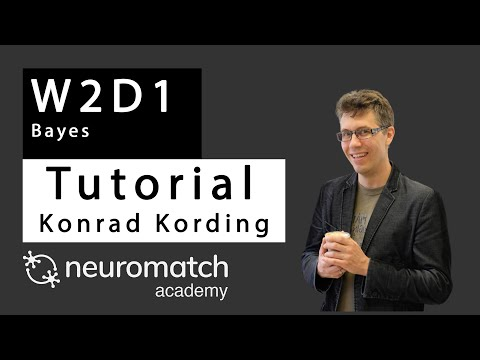

In [21]:
#@title Video: Outro
video = YouTubeVideo(id='YIFGXOsi0_A', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video